In [29]:
import pandas as pd
import pandas as pd
import glob
import tqdm
import re
from nltk.stem import WordNetLemmatizer
import nltk
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.callbacks.callbacks import EarlyStopping
from sklearn.decomposition import TruncatedSVD



In [2]:
path = 'democrats' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,  error_bad_lines=False, warn_bad_lines=False)
    li.append(df)

democrats = pd.concat(li, axis=0, ignore_index=True)

In [3]:
path = 'republicans' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,  error_bad_lines=False, warn_bad_lines=False)
    li.append(df)

republicans = pd.concat(li, axis=0, ignore_index=True)

In [4]:
republicans["IsDemocrat"] = 0
democrats["IsDemocrat"] = 1
df = pd.concat([republicans, democrats], axis=0)

In [5]:
df.reset_index(drop=True, inplace=True)

In [6]:
# replace field that's entirely space (or empty) with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# drop rows that have no text values
df = df.dropna(subset=["Text"]) 

In [7]:
# Removing links from tweets

for index, value in tqdm.tqdm(enumerate(df["Text"].values)):
    clean_tweet = re.sub(r'http\S+', '', value)
    if clean_tweet:
        df["Text"][index] = clean_tweet

0it [00:00, ?it/s]C:\Users\cemsaftekindantel\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
75915it [00:05, 14030.55it/s]


In [8]:
df = df[["Text", "IsDemocrat"]]

In [9]:
democrat_tweets = df[df["IsDemocrat"]==1]["Text"]
republican_tweets = df[df["IsDemocrat"]==0]["Text"]

In [10]:
def my_tokenizer(s):
    
    s = s.lower()
    
    # split string into words (tokens)
    tokens = nltk.tokenize.word_tokenize(s)
    
    # Removing words with less than 2 characters
    tokens = [t for t in tokens if len(t)>2]
    
    # Turning words into its base form
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    
    # Removing stopwords
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

In [11]:
stopwords = set(w.rstrip() for w in open("stopwords.txt"))

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

In [13]:
word_index_map = {}
current_index = 0



democrat_tokenized = []
republican_tokenized = []

for tweet in democrat_tweets:
    # Tokenize each review
    tokens = my_tokenizer(tweet)
    democrat_tokenized.append(tokens)
    for token in tokens:
        
        # Add the token as a key to the dictionary if it's not in it. Set the value of the key to it's index.
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index +=1
            
            
for tweet in republican_tweets:
    # Tokenize each review
    tokens = my_tokenizer(tweet)
    republican_tokenized.append(tokens)
    for token in tokens:
        
        # Add the token as a key to the dictionary if it's not in it. Set the value of the key to it's index.
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index +=1


In [14]:
def tokens_to_vector(tokens, label):
    # length of vocabulary + label length
    x = np.zeros(len(word_index_map)+1)
    for t in tokens:
        i = word_index_map[t]
        x[i] +=1
    x = x / x.sum()
    x[-1] = label
    return x

In [15]:
# Total observations
N = len(democrat_tokenized) + len(republican_tokenized)

data = np.zeros((N, len(word_index_map)+1))
i=0

for tokens in democrat_tokenized:
    # 1 for label
    xy = tokens_to_vector(tokens, 1)
    data[i,:] = xy
    i+=1
for tokens in republican_tokenized:
    # 0 for label
    xy = tokens_to_vector(tokens, 0)
    data[i,:] = xy
    i+=1

C:\Users\cemsaftekindantel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [16]:
# Shuffling our data before splitting 
np.random.shuffle(data)
X = data[:,:-1]
y = data[:,-1]

# Replacing nans with 0 in our features.
nan_positions = np.isnan(X)
X[nan_positions] = 0

In [17]:
# Splitting the data

X_train = X[:-30000,]
y_train = y[:-30000,]
X_test = X[-30000:,]
y_test = y[-30000:,]
del X

In [18]:
# Baseline model with LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification rate {}.".format(accuracy_score(y_test, y_pred)))

C:\Users\cemsaftekindantel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification rate 0.7792666666666667.


In [19]:
# One hot encoding our labels and splitting them
y = to_categorical(y)

y_train = y[:-30000,]
y_test = y[-30000:,]

In [21]:
# Reducing the number of features
tsvd = TruncatedSVD(n_components = 500)
X_train = tsvd.fit_transform(X_train)

In [22]:
X_train.shape

(45915, 500)

In [25]:
X_test = tsvd.transform(X_test)

In [26]:
X_test.shape

(30000, 500)

In [42]:
# Training a basic shallow NN model with 2 hidden layers with 10 folds cross validation
num_folds = 10
fold_scores = []
fold_number = 1
kf = KFold(n_splits = num_folds, shuffle = True, random_state = 42)
test_preds = np.zeros((len(X_test), 2))
valid_preds = np.zeros((X_train.shape[0],2))
for train_index, val_index in kf.split(X_train, y_train):
    train_X = X_train[train_index, :]
    train_y = y_train[train_index]
    
    val_X = X_train[val_index, :]
    val_y = y_train[val_index]
    
    model = Sequential([
        Dense(1024, input_shape=(X_train.shape[1],)),
        Activation('relu'),
        Dense(512),
        Activation('relu'),
        Dense(2),
        Activation('sigmoid'),
    ])
    
    # Setting callback
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics = ['accuracy'])
    
    model.fit(train_X, train_y, epochs = 100, validation_data=(val_X, val_y), callbacks = [es], verbose = 2)
    
    # OOF Predictions
    preds = model.predict(val_X)
    valid_preds[val_index] = preds
    
    # OOF Score
    fold_score = accuracy_score(np.argmax(val_y, axis=1), np.argmax(preds, axis=1))
    fold_scores.append(fold_score)
    print("Classification rate for fold number {} is {}.".format(fold_number, fold_score))
    fold_number += 1
    
    # Predicting test set
    test_preds += model.predict(X_test)/num_folds
print(fold_scores)

Train on 41323 samples, validate on 4592 samples
Epoch 1/100
 - 21s - loss: 0.4667 - accuracy: 0.7681 - val_loss: 0.4120 - val_accuracy: 0.8057
Epoch 2/100
 - 21s - loss: 0.4051 - accuracy: 0.7999 - val_loss: 0.4112 - val_accuracy: 0.7995
Epoch 3/100
 - 20s - loss: 0.3746 - accuracy: 0.8177 - val_loss: 0.3941 - val_accuracy: 0.8189
Epoch 4/100
 - 20s - loss: 0.3426 - accuracy: 0.8339 - val_loss: 0.3964 - val_accuracy: 0.8112
Epoch 5/100
 - 20s - loss: 0.3043 - accuracy: 0.8527 - val_loss: 0.4244 - val_accuracy: 0.8146
Epoch 6/100
 - 20s - loss: 0.2649 - accuracy: 0.8728 - val_loss: 0.4348 - val_accuracy: 0.8150
Epoch 7/100
 - 20s - loss: 0.2342 - accuracy: 0.8908 - val_loss: 0.4812 - val_accuracy: 0.8108
Epoch 8/100
 - 20s - loss: 0.2041 - accuracy: 0.9043 - val_loss: 0.5440 - val_accuracy: 0.8061
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping
Classification rate for fold number 1 is 0.8190331010452961.
Train on 41323 samples, validate on 4592 sample

Epoch 7/100
 - 20s - loss: 0.2336 - accuracy: 0.8897 - val_loss: 0.5091 - val_accuracy: 0.7953
Epoch 8/100
 - 20s - loss: 0.2069 - accuracy: 0.9032 - val_loss: 0.5500 - val_accuracy: 0.7923
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping
Classification rate for fold number 9 is 0.8009148333696362.
Train on 41324 samples, validate on 4591 samples
Epoch 1/100
 - 20s - loss: 0.4643 - accuracy: 0.7707 - val_loss: 0.4318 - val_accuracy: 0.7905
Epoch 2/100
 - 20s - loss: 0.4077 - accuracy: 0.8006 - val_loss: 0.4137 - val_accuracy: 0.7945
Epoch 3/100
 - 20s - loss: 0.3756 - accuracy: 0.8178 - val_loss: 0.4052 - val_accuracy: 0.7950
Epoch 4/100
 - 20s - loss: 0.3425 - accuracy: 0.8347 - val_loss: 0.4541 - val_accuracy: 0.7847
Epoch 5/100
 - 20s - loss: 0.3054 - accuracy: 0.8526 - val_loss: 0.4360 - val_accuracy: 0.7888
Epoch 6/100
 - 20s - loss: 0.2676 - accuracy: 0.8733 - val_loss: 0.4615 - val_accuracy: 0.8139
Epoch 7/100
 - 20s - loss: 0.2350 - accuracy: 0

In [43]:
# Final classification score for the model is 80%
print("Classification rate {}.".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_preds, axis=1))))

Classification rate 0.8042.


In [48]:
# Visualize the data

def visualize(label):
    words = ""
    for msg in df[df["IsDemocrat"]==label]["Text"]:
        msg = msg.lower()
        words += msg + " "
    wordcloud = WordCloud(width=1700, height=1000, background_color = "white").generate(words)
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

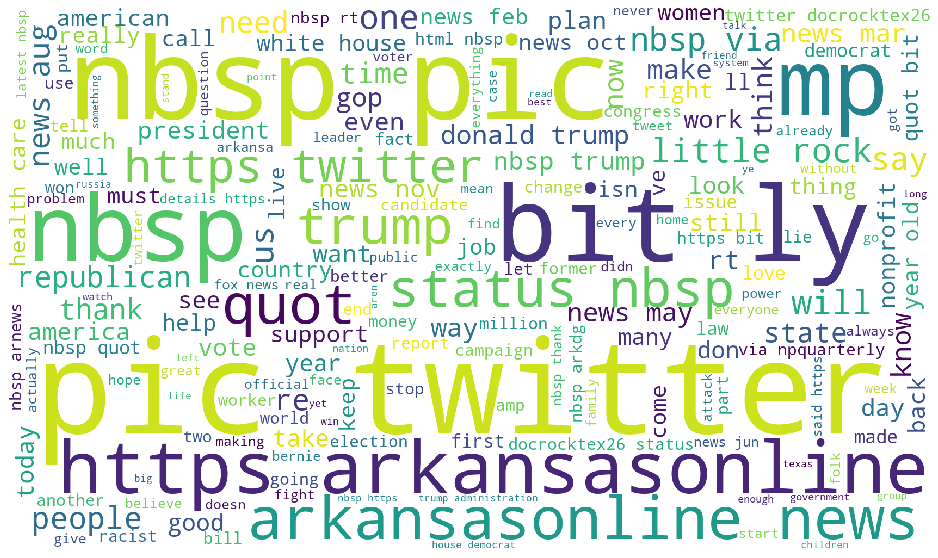

In [49]:
# Visualising words used by democrat influencers
visualize(1)

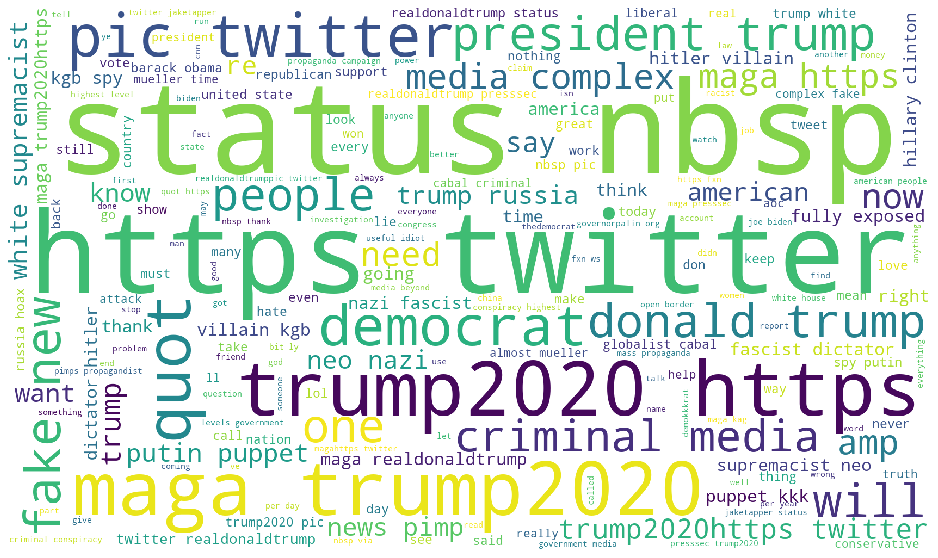

In [50]:
# Visualising words used by republican influencers
visualize(0)